<a href="https://colab.research.google.com/github/fcochaux/MINE-4101_Taller_4/blob/main/MINE_4101_Taller_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación de Pipeline para la transformación, entrenamiento y predicción

__Estudiantes:__

Nicole Bahamón Martínez \
Francisco José Chaux Guzmán \
Iván Arturo Salazar

Enlace al repositorio:

In [195]:
!git clone "https://github.com/fcochaux/MINE-4101_Taller_4.git"

fatal: destination path 'MINE-4101_Taller_4' already exists and is not an empty directory.


Carga de librerías necesarias:

In [196]:
# procesamiento

import numpy as np
import pandas as pd

# visualización

import matplotlib.pyplot as plt
import seaborn as sns

# aprendizaje

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# otros

import warnings

El siguiente código impide la generación de mensajes de advertencia:

In [197]:
warnings.filterwarnings('ignore')

El siguiente código permite una visualización de resultados más atractiva:

In [198]:
set_config(display="diagram")

## 1) Revisión del conjunto de datos y de las transformaciones que serán necesarias

Lectura del conjunto de datos:

In [199]:
# lectura del conjunto de datos
df = pd.read_json('/content/MINE-4101_Taller_4/datos/DataSet_Entrenamiento_v1.json')
# convierte nombres a minúsculas
df.columns = df.columns.str.lower()
# revisa 5 casos al azar
df.sample(5)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
5008,1089-XZWHH,Female,0,Yes,Yes,24,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,19.70,494.05,No
1809,4365-MSDYN,Male,0,Yes,No,8,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),19.55,161.15,No
1786,5970-GHJAW,Male,0,Yes,Yes,46,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.95,862.4,No
3057,1353-GHZOS,Male,0,Yes,No,22,Yes,No,DSL,Yes,...,No,No,Yes,No,One year,Yes,Bank transfer (automatic),59.75,1374.35,No
5896,2452-MRMZF,Female,1,Yes,No,72,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),25.70,1937.4,No


Características de la base:

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        6000 non-null   object 
 1   gender            6000 non-null   object 
 2   seniorcitizen     6000 non-null   int64  
 3   partner           6000 non-null   object 
 4   dependents        6000 non-null   object 
 5   tenure            6000 non-null   int64  
 6   phoneservice      6000 non-null   object 
 7   multiplelines     6000 non-null   object 
 8   internetservice   6000 non-null   object 
 9   onlinesecurity    6000 non-null   object 
 10  onlinebackup      6000 non-null   object 
 11  deviceprotection  6000 non-null   object 
 12  techsupport       6000 non-null   object 
 13  streamingtv       6000 non-null   object 
 14  streamingmovies   6000 non-null   object 
 15  contract          6000 non-null   object 
 16  paperlessbilling  6000 non-null   object 


Casi todas las variables son categóricas, con la excepción de `seniorcitizen`, `tenure` y `monthlycharges`. Sin embargo, la variable `totalcharges` está mal clasificada (esto se ve en la muestra de observaciones que se vio en la lectura), por lo que debe transformarse a numérica:

In [201]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        6000 non-null   object 
 1   gender            6000 non-null   object 
 2   seniorcitizen     6000 non-null   int64  
 3   partner           6000 non-null   object 
 4   dependents        6000 non-null   object 
 5   tenure            6000 non-null   int64  
 6   phoneservice      6000 non-null   object 
 7   multiplelines     6000 non-null   object 
 8   internetservice   6000 non-null   object 
 9   onlinesecurity    6000 non-null   object 
 10  onlinebackup      6000 non-null   object 
 11  deviceprotection  6000 non-null   object 
 12  techsupport       6000 non-null   object 
 13  streamingtv       6000 non-null   object 
 14  streamingmovies   6000 non-null   object 
 15  contract          6000 non-null   object 
 16  paperlessbilling  6000 non-null   object 


Ahora la variable `totalcharges` tiene faltantes. Para saber como imputar, se revisa su histograma:

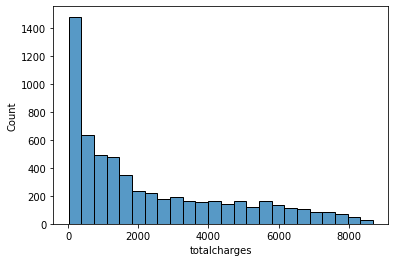

In [202]:
sns.histplot(df['totalcharges'])

Debido a su distribución concentrada en valores bajos, se imputa por la mediana:

In [203]:
df['totalcharges']= df['totalcharges'].fillna(df['totalcharges'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        6000 non-null   object 
 1   gender            6000 non-null   object 
 2   seniorcitizen     6000 non-null   int64  
 3   partner           6000 non-null   object 
 4   dependents        6000 non-null   object 
 5   tenure            6000 non-null   int64  
 6   phoneservice      6000 non-null   object 
 7   multiplelines     6000 non-null   object 
 8   internetservice   6000 non-null   object 
 9   onlinesecurity    6000 non-null   object 
 10  onlinebackup      6000 non-null   object 
 11  deviceprotection  6000 non-null   object 
 12  techsupport       6000 non-null   object 
 13  streamingtv       6000 non-null   object 
 14  streamingmovies   6000 non-null   object 
 15  contract          6000 non-null   object 
 16  paperlessbilling  6000 non-null   object 


Histograma de variables numéricas:

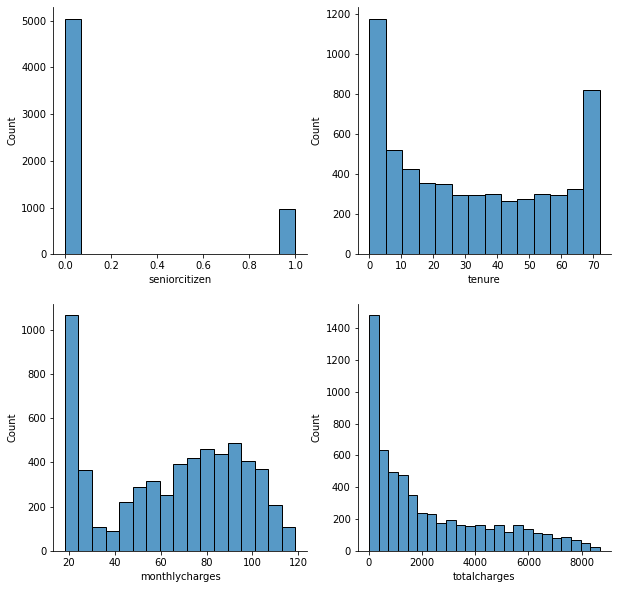

In [205]:
figure, axis = plt.subplots(2, 2, figsize=(10, 10))
fila = -1
columna = -1
for k in df.describe().columns:
    columna = columna + 1
    if columna == 2:
        columna = 0
    if columna == 0:
        fila = fila + 1
    if fila == 2:
        fila = 0
    sns.histplot(df[k], ax=axis[fila,columna])
sns.despine(figure)

La variable `seniorcitizen` es binaria, no continua. Para las otras se revisa la presencia de valores atípicos:

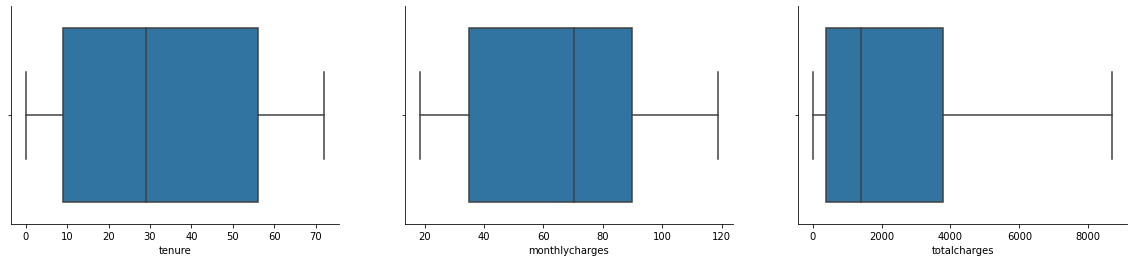

In [206]:
figure, axis = plt.subplots(1, 3, figsize=(20, 4))
indice = -1
for k in ['tenure','monthlycharges','totalcharges']:
    indice = indice + 1
    sns.boxplot(df[k], ax=axis[indice])
sns.despine(figure)

No existen valores extremos. Se revisan también las variables categóricas:

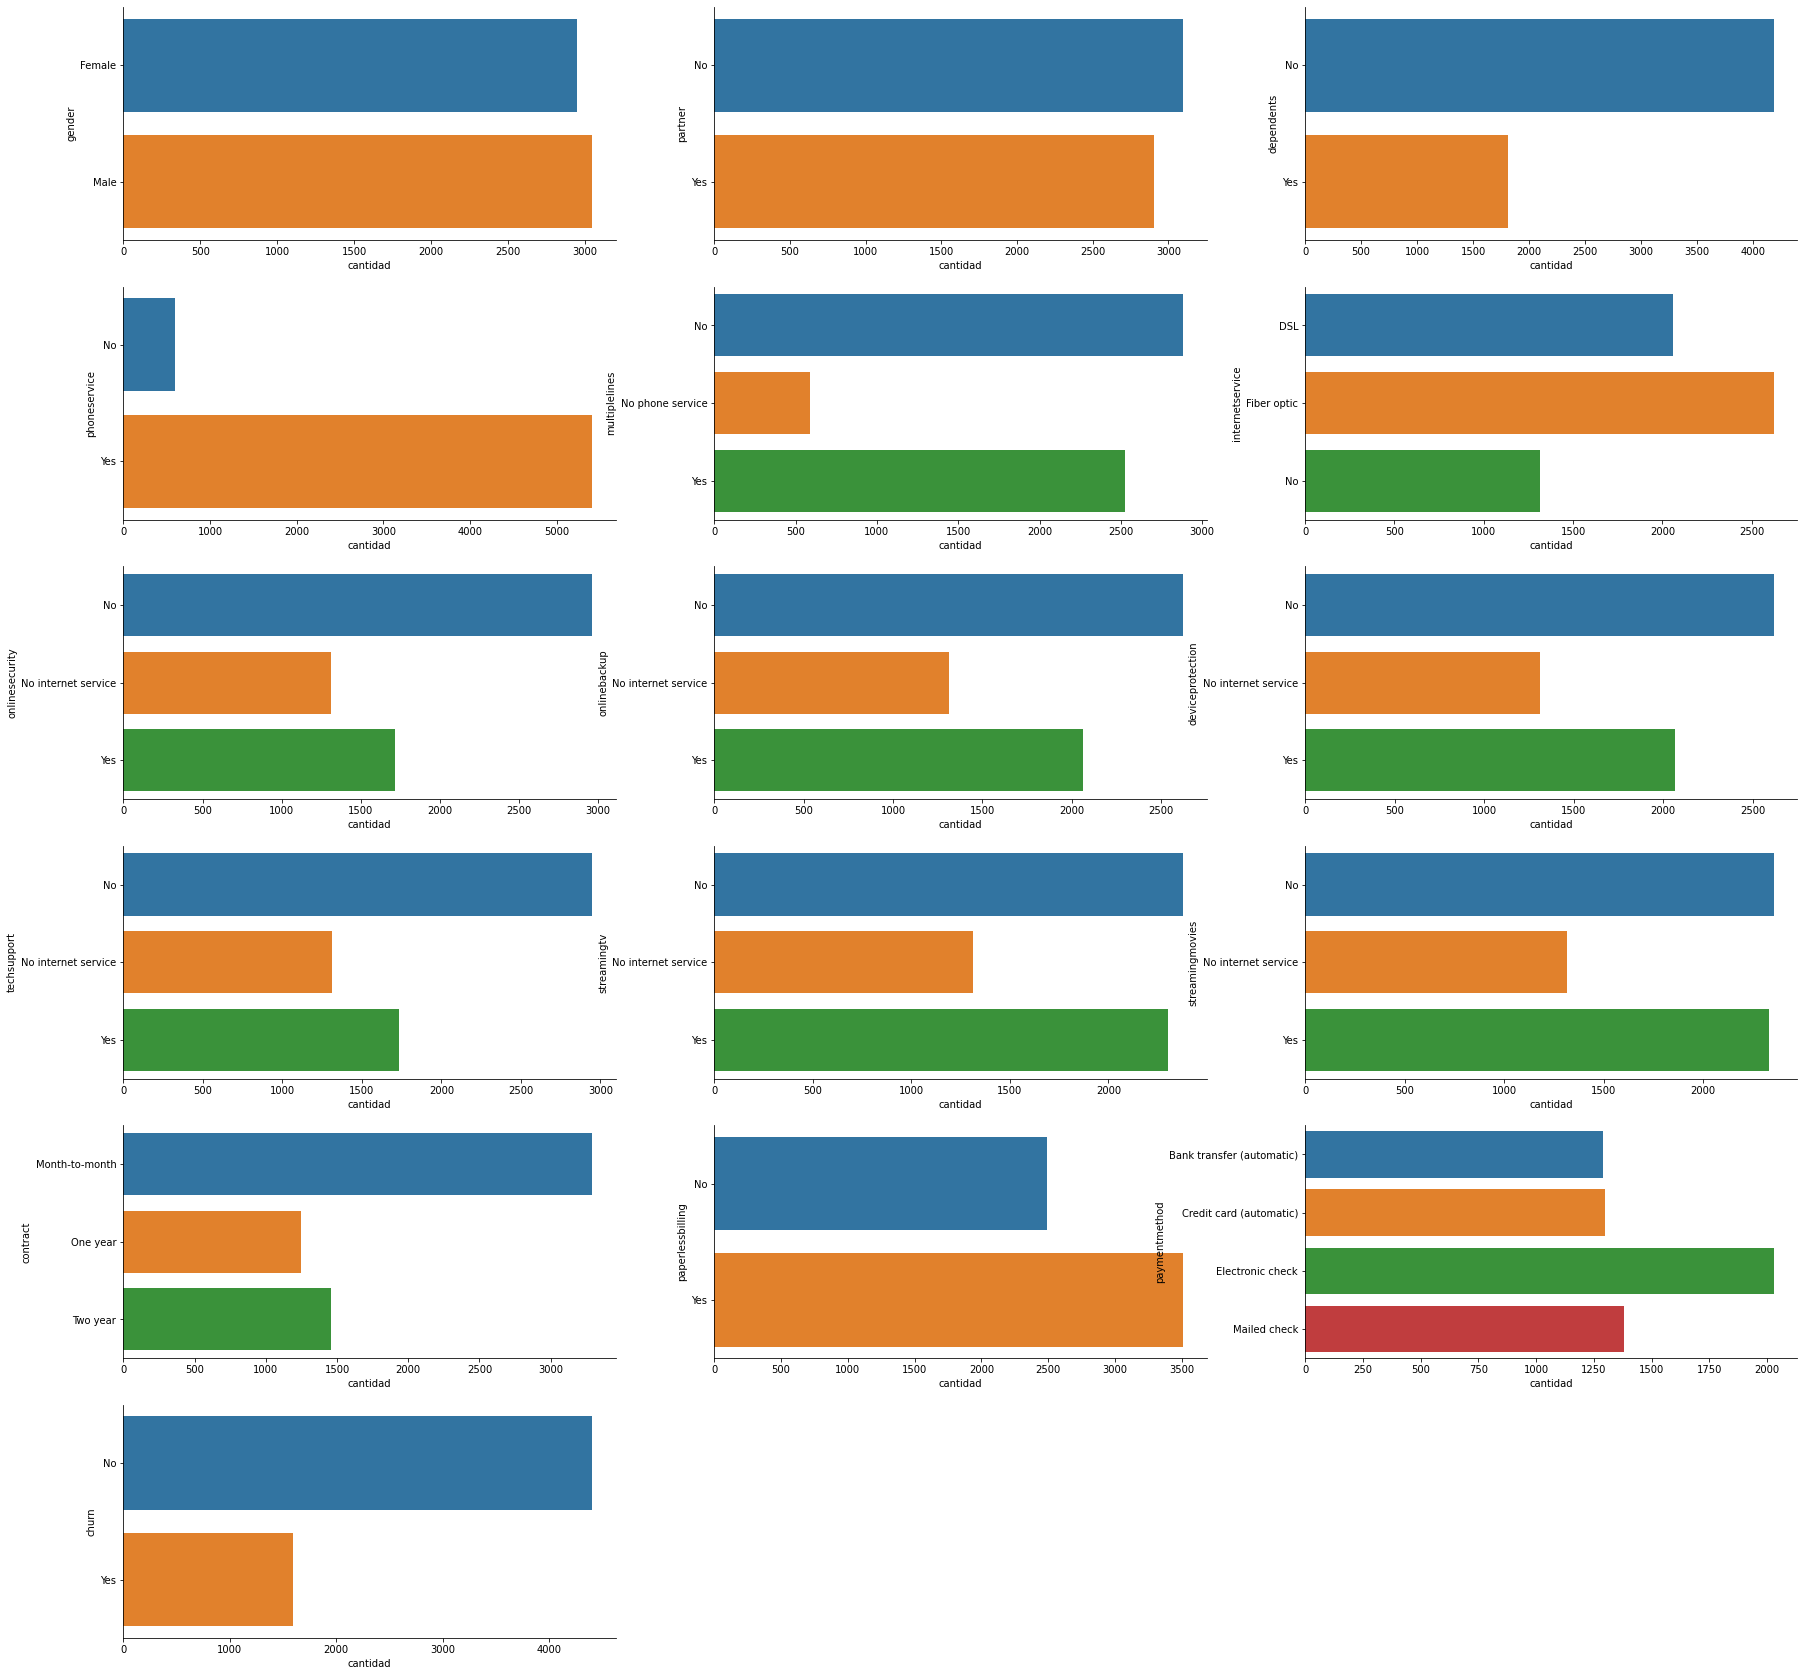

In [207]:
figure, axis = plt.subplots(6, 3, figsize=(30, 30))
fila = -1
columna = -1
for k in df.select_dtypes(include=['object']).columns.drop('customerid'):
    columna = columna + 1
    if columna == 3:
        columna = 0
    if columna == 0:
        fila = fila + 1
    if fila == 6:
        fila = 0
    cuadro = df[[k]].groupby(k)[k] \
                    .count() \
                    .reset_index(name='cantidad')
    sns.barplot(data = cuadro, y = k, x = 'cantidad', ax=axis[fila,columna])
figure.delaxes(axis[5,1])
figure.delaxes(axis[5,2])
sns.despine(figure)

En este caso no parece haber ningún problema, por lo que pueden usarse todas las variables. Solo se hace la transformación a variable numéricas de acuerdo a las necesidades de los algoritmos:

In [208]:
# convierte variable objetivo a numérica
df['churn'] = np.where(df['churn'] == 'Yes', 1, 0)
# aplicación de one hot encoder
for k in df.select_dtypes(include=['object']).columns:
    onehotencoder = OneHotEncoder()
    var = onehotencoder.fit_transform(df[[k]])
    df[onehotencoder.categories_[0]] = var.toarray()
    del df[k]
# muestra algunos registros
df.sample(5)

,seniorcitizen,tenure,monthlycharges,totalcharges,churn,0002-ORFBO,0003-MKNFE,0004-TLHLJ,0013-EXCHZ,0013-MHZWF,...,DSL,Fiber optic,No internet service,Month-to-month,One year,Two year,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
4370,0,53,69.70,3729.60,0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3254,0,1,24.00,24.00,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1025,1,1,69.25,69.25,1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5193,0,67,84.80,5598.30,0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4978,0,5,74.65,383.65,0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


En resumen, se aplicaron los siguientes tratamientos:

- Corrección de variable `totalcharges`.
- Imputación de variable `totalcharges`.
- Conversión de variable objetivo a variable binaria.
- Aplicación de one hot encoder

En el Pipeline, lo ideal será incluir estas transformaciones para poder encapsular el proceso de limpieza de datos.

## 2) Construcción de Pipelines

Lectura del conjunto de datos:

In [209]:
df = pd.read_json('/content/MINE-4101_Taller_4/datos/DataSet_Entrenamiento_v1.json')
df.columns = df.columns.str.lower()

Separaciones:

In [211]:
objetivo = 'churn'
identificador = 'customerid'
caracteristicas = df.columns.drop(objetivo).drop(identificador)
df['totalcharges'] = pd.to_numeric(df['totalcharges']) # corrige variable con mal formato
numericas = df[caracteristicas].select_dtypes('number').columns
#numericas = df[caracteristicas].select_dtypes('number').columns.append(pd.Index(['totalcharges']))
categoricas = pd.Index(np.setdiff1d(caracteristicas, numericas))
x_entrenamiento, x_prueba, y_entrenamiento, y_prueba = train_test_split(
    df.drop(columns=[objetivo,identificador]), df[objetivo], test_size=.2, random_state=32234, stratify=df[objetivo]
    )

Construcción del pipeline de procesamiento:

In [212]:
"""
Acá falta incluir la conversión de la variable totalcharges a numérica, la cual
convertí atrás utilizando pandas.
"""

pipe_numerico = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

pipe_categorico = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

preprocesadores = ColumnTransformer(transformers=[
    ('num', pipe_numerico, numericas),
    ('cat', pipe_categorico, categoricas)
])

### 2.1) Regresión logística

In [213]:
pipe1 = Pipeline([
    ('preprocessors', preprocesadores),
    ('model', LogisticRegression())
])

pipe1.fit(x_entrenamiento, y_entrenamiento)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['contract', 'dependents', 'deviceprotection', 'gender',
       'internetservice', 'multiplelines', 'onlinebackup', 'onlinesecurity',
       'paperlessbilling', 'partner', 'paymentmethod', 'phoneservice',
       'streamingmovies', 'streamingtv', 'techsupport'],
      dtype='object'))])),
                ('model', LogisticRegression())])

### 2.2) Máquina de vectores de soporte

In [214]:
pipe2 = Pipeline([
    ('preprocessors', preprocesadores),
    ('model', SVC())
])

pipe2.fit(x_entrenamiento, y_entrenamiento)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['contract', 'dependents', 'deviceprotection', 'gender',
       'internetservice', 'multiplelines', 'onlinebackup', 'onlinesecurity',
       'paperlessbilling', 'partner', 'paymentmethod', 'phoneservice',
       'streamingmovies', 'streamingtv', 'techsupport'],
      dtype='object'))])),
                ('model', SVC())])

### 2.3) Árboles de decisión

In [215]:
pipe3 = Pipeline([
    ('preprocessors', preprocesadores),
    ('model', DecisionTreeClassifier())
])

pipe3.fit(x_entrenamiento, y_entrenamiento)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['contract', 'dependents', 'deviceprotection', 'gender',
       'internetservice', 'multiplelines', 'onlinebackup', 'onlinesecurity',
       'paperlessbilling', 'partner', 'paymentmethod', 'phoneservice',
       'streamingmovies', 'streamingtv', 'techsupport'],
      dtype='object'))])),
                ('model', DecisionTreeClassifier())])

### 2.4) Bosques aleatorios

In [216]:
pipe4 = Pipeline([
    ('preprocessors', preprocesadores),
    ('model', RandomForestClassifier(random_state = 23343))
])

pipe4.fit(x_entrenamiento, y_entrenamiento)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['contract', 'dependents', 'deviceprotection', 'gender',
       'internetservice', 'multiplelines', 'onlinebackup', 'onlinesecurity',
       'paperlessbilling', 'partner', 'paymentmethod', 'phoneservice',
       'streamingmovies', 'streamingtv', 'techsupport'],
      dtype='object'))])),
                ('model', RandomForestClassifier(random_state=23343))])

### 2.5) Red neuronal

In [217]:
pipe5 = Pipeline([
    ('preprocessors', preprocesadores),
    ('model', MLPClassifier())
])

pipe5.fit(x_entrenamiento, y_entrenamiento)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['contract', 'dependents', 'deviceprotection', 'gender',
       'internetservice', 'multiplelines', 'onlinebackup', 'onlinesecurity',
       'paperlessbilling', 'partner', 'paymentmethod', 'phoneservice',
       'streamingmovies', 'streamingtv', 'techsupport'],
      dtype='object'))])),
                ('model', MLPClassifier())])